In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
!nvidia-smi

Wed Mar 23 15:23:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!ln -s /content/gdrive/My\ Drive/ /mydrive

In [4]:
%cd /mydrive/Multi-label\ Classification/FITW

/content/gdrive/My Drive/Multi-label Classification/FITW


In [5]:
!ls

APP  DenseNet121.ipynb	Enhanced.csv  Raw.csv	      VGG19.ipynb
CM   enh		raw	      ResNet50.ipynb  Xception.ipynb
CM2  Enhanced		Raw	      VGG16.ipynb


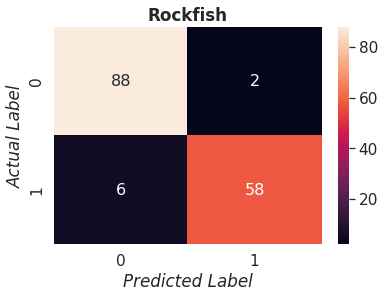

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = [[88,  2],[ 6, 58]]
#raw array = [ [[88,  2],[ 6, 58]], [[93,  3],[ 5, 53]],  [[93,  3],[ 2, 56]] ]
#enh array([[[93,  0], [ 3, 58]],  [[88,  3],  [ 7, 56]],  [[95,  1], [ 1, 57]]])  
df_cm = pd.DataFrame(array, range(2), range(2))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size


plt.title('Rockfish', fontweight="bold")
plt.ylabel('Actual Label', fontstyle="italic")
plt.xlabel('Predicted Label', fontstyle="italic")
plt.savefig('CM2/R-R.pdf')
plt.show()
#plt.legend(['train', 'val'], loc='upper right')

#plt.save()

## 1. Preprocessing

In [6]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import PIL
import PIL.Image
import pandas as pd
import pathlib, datetime

In [7]:
df=pd.read_csv("Raw.csv")
df.columns = df.columns.str.replace(' ','')
df.head()

,filename,Rockfish,Starfish,Tilefish
0,2--6----Copy_jpg.rf.f98d10b8ed8511d0d1f52b56f6...,0,0,1
1,Set2_DSCN1438-JPG_0---Copy_jpg.rf.fa090bff4d1b...,1,1,0
2,x3---Copy_bmp.rf.fa388522a25169dd7fdd3efa08f76...,0,1,0
3,dddd_bmp.rf.fac67cf27ddc05937c053e6a06d491bf.jpg,0,1,0
4,49--6-_bmp.rf.fc7ef0036ddf451ecf97987a3c3cf10f...,0,0,1


In [8]:
#df[['filename','Rockfish', 'Starfish', 'Tilefish']].groupby(['Rockfish', 'Starfish', 'Tilefish']).agg(['count'])


In [9]:
LABELS=["Rockfish", "Starfish", "Tilefish"]

In [10]:
data_dir = pathlib.Path("Raw")
filenames = list(data_dir.glob('*.jpg'))
fnames=[]
for fname in filenames:
  fnames.append(str(fname))

print(len(fnames))


767


In [11]:
ds_size= len(fnames)
print("Number of images in folders: ", ds_size)

number_of_selected_samples=2000
filelist_ds = tf.data.Dataset.from_tensor_slices(fnames[:number_of_selected_samples])

ds_size= filelist_ds.cardinality().numpy()
print("Number of selected samples for dataset: ", ds_size)

Number of images in folders:  767
Number of selected samples for dataset:  767


In [12]:
def get_label(file_path):
  parts = tf.strings.split(file_path, '/')
  file_name= parts[-1]
  labels= df[df["filename"]==file_name][LABELS].to_numpy().squeeze()
  return tf.convert_to_tensor(labels)

In [13]:
IMG_WIDTH, IMG_HEIGHT = 448 , 448
def decode_img(img):
  #color images
  img = tf.image.decode_jpeg(img, channels=3) 
  #convert unit8 tensor to floats in the [0,1]range
  img = tf.image.convert_image_dtype(img, tf.float32) 
  #resize 
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT]) 

In [14]:
def combine_images_labels(file_path: tf.Tensor):
  label = get_label(file_path)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [15]:
train_ratio = 0.80
ds_train=filelist_ds.take(ds_size*train_ratio)
ds_test=filelist_ds.skip(ds_size*train_ratio)

In [16]:
BATCH_SIZE= 64

In [17]:
ds_train=ds_train.map(lambda x: tf.py_function(func=combine_images_labels,
          inp=[x], Tout=(tf.float32,tf.int64)),
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=False)

In [18]:
ds_test= ds_test.map(lambda x: tf.py_function(func=combine_images_labels,
          inp=[x], Tout=(tf.float32,tf.int64)),
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=False)

In [19]:
ds_test

<ParallelMapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int64, name=None))>

In [20]:
def covert_onehot_string_labels(label_string,label_onehot):
  labels=[]
  for i, label in  enumerate(label_string):
     if label_onehot[i]:
       labels.append(label)
  if len(labels)==0:
    labels.append("NONE")
  return labels

9 samples from the dataset


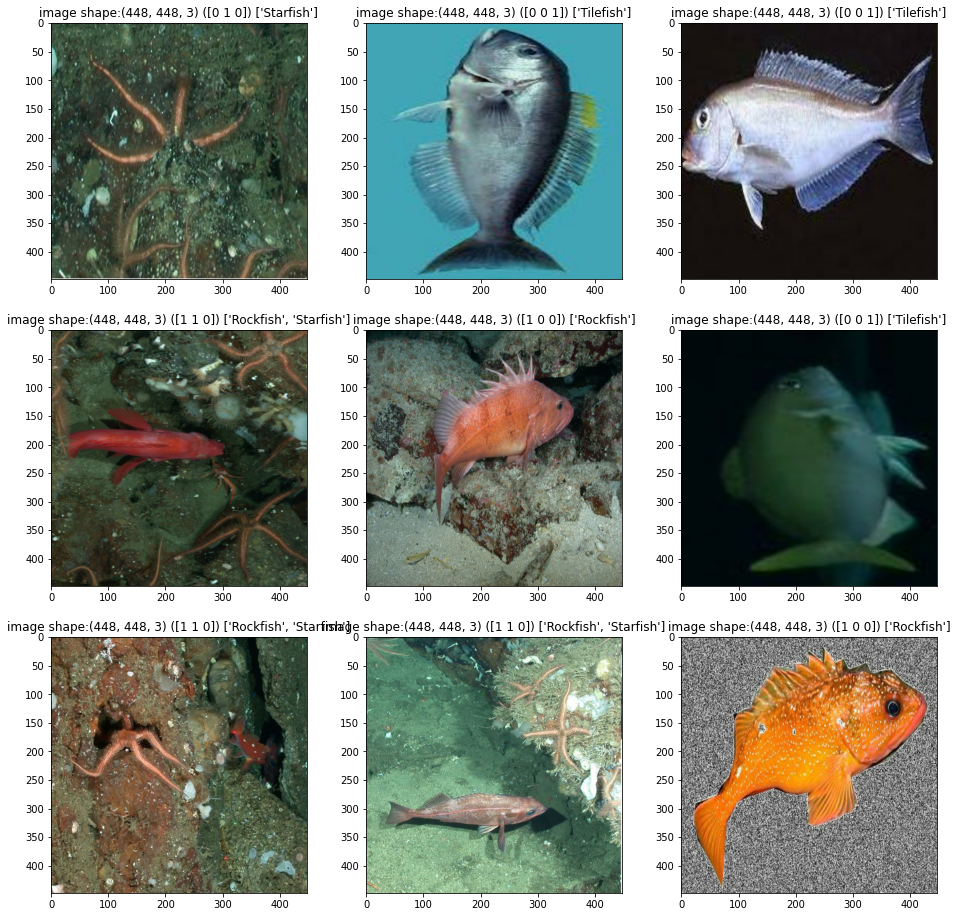

In [21]:
def show_samples(dataset):
  fig=plt.figure(figsize=(16, 16))
  columns = 3
  rows = 3
  print(columns*rows,"samples from the dataset")
  i=1
  for a,b in dataset.take(columns*rows): 
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(a))
    plt.title("image shape:"+ str(a.shape)+" ("+str(b.numpy()) +") "+ 
              str(covert_onehot_string_labels(LABELS,b.numpy())))
    i=i+1
  plt.show()
show_samples(ds_test)

In [22]:
#buffer_size = ds_train_resize_scale.cardinality().numpy()/10
#ds_resize_scale_batched=ds_raw.repeat(3).shuffle(buffer_size=buffer_size).batch(64, )

ds_train_batched=ds_train.batch(BATCH_SIZE).cache().prefetch(tf.data.experimental.AUTOTUNE) 
ds_test_batched=ds_test.batch(BATCH_SIZE).cache().prefetch(tf.data.experimental.AUTOTUNE)

print("Number of batches in train: ", ds_train_batched.cardinality().numpy())
print("Number of batches in test: ", ds_test_batched.cardinality().numpy())


Number of batches in train:  10
Number of batches in test:  3


## 2. Create a Keras CNN model by using Transfer learning

In [23]:
base_model = keras.applications.DenseNet121(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(448, 448, 3), #  expects min 32 x 32
    include_top=False)  # Do not include the ImageNet classifier at the top.
base_model.trainable = False

29097984/29084464 [==============================] - 1s 0us/step


In [24]:
number_of_classes = 3

In [25]:
inputs = keras.Input(shape=(448 , 448 , 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
initializer = tf.keras.initializers.GlorotUniform(seed=42)

activation =  tf.keras.activations.sigmoid #None  # tf.keras.activations.sigmoid or softmax

outputs = keras.layers.Dense(number_of_classes,
                             kernel_initializer=initializer,
                             activation=activation)(x) 
model = keras.Model(inputs, outputs)

In [26]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(), # default from_logits=False
              metrics=[keras.metrics.BinaryAccuracy()])

In [27]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 14, 14, 1024)      7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 3)                 3075      
                                                                 
Total params: 7,040,579
Trainable params: 3,075
Non-trainable params: 7,037,504
_________________________________________________________________
None


In [28]:
history=model.fit(ds_train_batched, validation_data=ds_test_batched, epochs=50)

Epoch 1/50
10/10 [==============================] - 160s 15s/step - loss: 0.7423 - binary_accuracy: 0.4731 - val_loss: 0.6099 - val_binary_accuracy: 0.6277
Epoch 2/50
10/10 [==============================] - 4s 402ms/step - loss: 0.5393 - binary_accuracy: 0.7216 - val_loss: 0.4617 - val_binary_accuracy: 0.8463
Epoch 3/50
10/10 [==============================] - 4s 402ms/step - loss: 0.4137 - binary_accuracy: 0.8733 - val_loss: 0.3715 - val_binary_accuracy: 0.9134
Epoch 4/50
10/10 [==============================] - 4s 402ms/step - loss: 0.3379 - binary_accuracy: 0.9032 - val_loss: 0.3149 - val_binary_accuracy: 0.9351
Epoch 5/50
10/10 [==============================] - 4s 402ms/step - loss: 0.2907 - binary_accuracy: 0.9260 - val_loss: 0.2780 - val_binary_accuracy: 0.9437
Epoch 6/50
10/10 [==============================] - 4s 403ms/step - loss: 0.2585 - binary_accuracy: 0.9358 - val_loss: 0.2519 - val_binary_accuracy: 0.9416
Epoch 7/50
10/10 [==============================] - 4s 403ms/ste

### Evaulate the model

In [29]:
ds= ds_test_batched
print("Test Accuracy: ", model.evaluate(ds)[1])

3/3 [==============================] - 1s 235ms/step - loss: 0.0989 - binary_accuracy: 0.9675
Test Accuracy:  0.9675324559211731


In [30]:
ds=ds_test
predictions= model.predict(ds.batch(batch_size=767).take(1))
print("A sample output from the last layer (model) ", predictions[0])
y=[]
print("10 Sample predictions:")
i = 0
for (pred,(a,b)) in zip(predictions,ds.take(767)):
  
  pred[pred>0.5]=1
  pred[pred<=0.5]=0
  print("predicted: " ,pred, str(covert_onehot_string_labels(LABELS, pred)),  
        "Actual Label: ("+str(covert_onehot_string_labels(LABELS,b.numpy())) +")")
  y.append(b.numpy())
  i=i+1
  print(i)

from sklearn.metrics import classification_report

print(classification_report(y, predictions, target_names=LABELS))

A sample output from the last layer (model)  [0.04851614 0.9989467  0.00132239]
10 Sample predictions:
predicted:  [0. 1. 0.] ['Starfish'] Actual Label: (['Tilefish'])
1
predicted:  [1. 1. 0.] ['Rockfish', 'Starfish'] Actual Label: (['Tilefish'])
2
predicted:  [0. 0. 1.] ['Tilefish'] Actual Label: (['Rockfish', 'Starfish'])
3
predicted:  [0. 0. 1.] ['Tilefish'] Actual Label: (['Starfish'])
4
predicted:  [1. 0. 0.] ['Rockfish'] Actual Label: (['Tilefish'])
5
predicted:  [1. 1. 0.] ['Rockfish', 'Starfish'] Actual Label: (['Rockfish'])
6
predicted:  [0. 0. 1.] ['Tilefish'] Actual Label: (['Rockfish', 'Starfish'])
7
predicted:  [1. 1. 0.] ['Rockfish', 'Starfish'] Actual Label: (['Rockfish', 'Starfish'])
8
predicted:  [1. 1. 0.] ['Rockfish', 'Starfish'] Actual Label: (['Rockfish'])
9
predicted:  [1. 0. 0.] ['Rockfish'] Actual Label: (['Rockfish'])
10
predicted:  [0. 1. 0.] ['Starfish'] Actual Label: (['Starfish'])
11
predicted:  [0. 0. 1.] ['Tilefish'] Actual Label: (['Tilefish'])
12
predic

In [31]:
print(len(y))

154


CASE INPUT IMAGE

Tilefish (0.969)
Rockfish (0.579)
Starfish (0.00191)


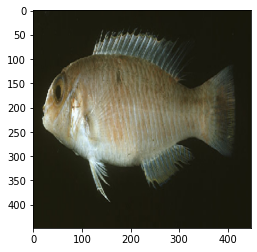

In [42]:
from keras.preprocessing import image

img = image.load_img('APP2/T2.jpg', target_size=(448,448,3))

img = image.img_to_array(img)
img = img/255.
plt.imshow(img)
img = np.expand_dims(img, axis=0)

classes = LABELS #Get array of all classes
proba = model.predict(img)  #Get probabilities for each class
sorted_categories = np.argsort(proba[0])[:-4:-1]  #Get class names for top 10 categories

#Print classes and corresponding probabilities
for i in range(3):
    print("{}".format(classes[sorted_categories[i]])+" ({:.3})".format(proba[0][sorted_categories[i]]))

In [ ]:
predictions.shape

(154, 3)

In [ ]:
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix

multilabel_confusion_matrix(y, predictions)

array([[[86,  4],
        [ 8, 56]],

       [[91,  5],
        [ 7, 51]],

       [[92,  4],
        [ 3, 55]]])

ValueError: ignored

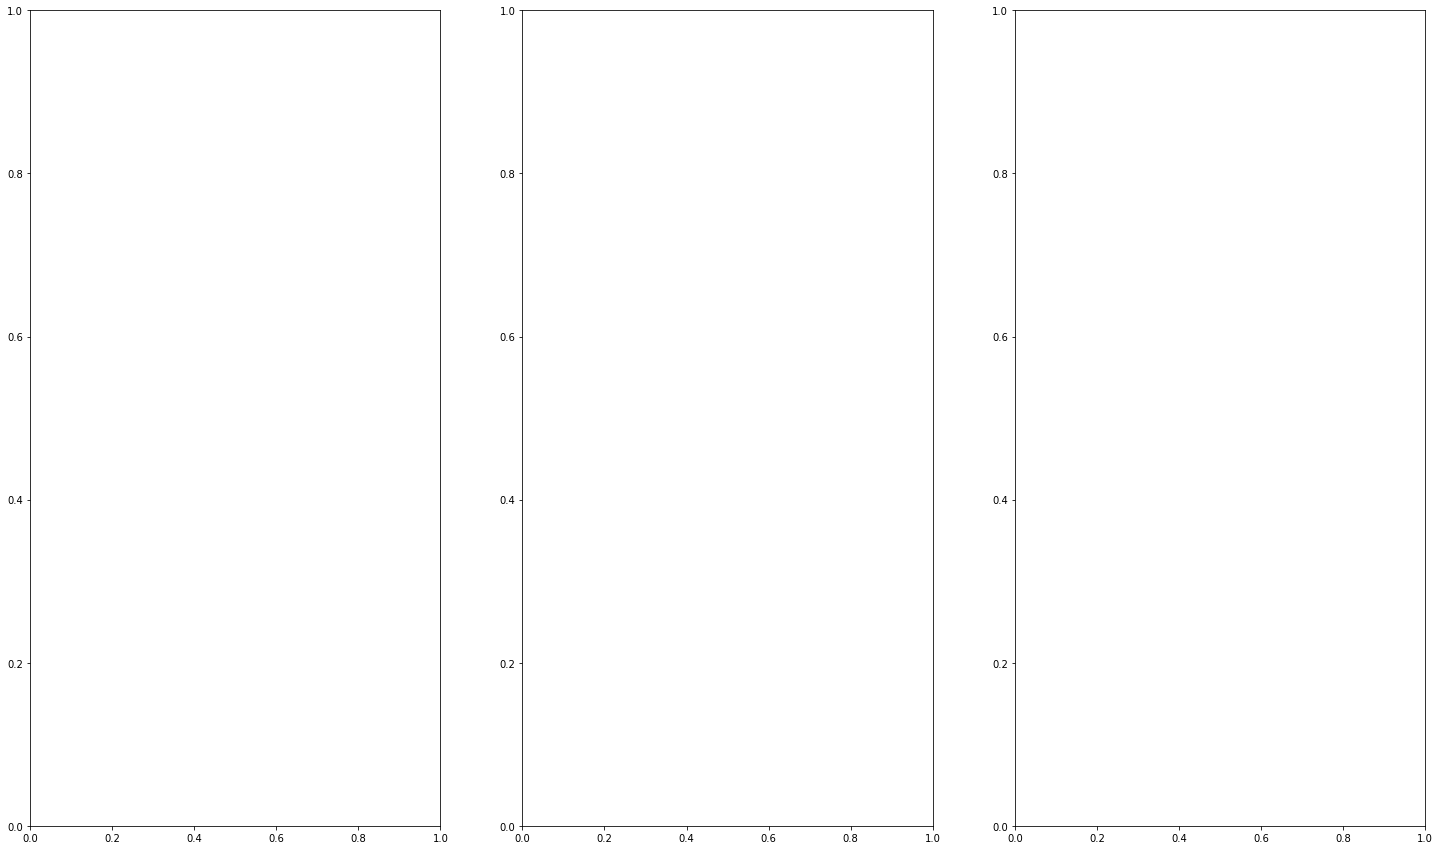

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_multilabel_classification
from sklearn.tree import DecisionTreeClassifier


y_test = y
y_pred = predictions

f, axes = plt.subplots(1, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(3):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test[:, i],
                                                   y_pred[:, i]),
                                  display_labels=[0, i])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'class {i}')
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix

print(multilabel_confusion_matrix(y, predictions))

[[[88  5]
  [ 8 53]]

 [[85  6]
  [10 53]]

 [[90  6]
  [ 6 52]]]


In [ ]:
import pandas as pd

df_confusion = pd.crosstab(y, predictions)
df_confusion

Exception: ignored

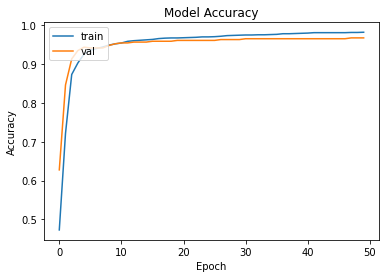

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('raw/Accuracy_Exp12.png', dpi=1200)
plt.show()

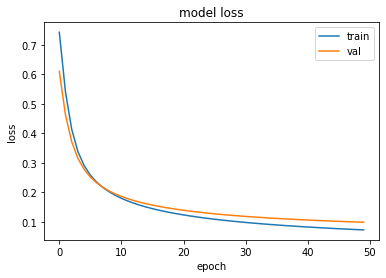

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.savefig('raw/Loss_Exp12.png', dpi=1200)
plt.show()

In [ ]:
!ls

enh  Enhanced  Enhanced.csv  raw  Raw  Raw.csv	VGG16.ipynb  VGG19.ipynb
